# 03 Evaluation: Homework

In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import auc, roc_auc_score, roc_curve, RocCurveDisplay, precision_score, recall_score, f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [63]:
import warnings
warnings.filterwarnings("ignore")

## Data Import

In [64]:
df = pd.read_csv('bank-full.csv', sep=";")

In [65]:
col_list = [
  'age',
  'job',
  'marital',
  'education',
  'balance',
  'housing',
  'contact',
  'day',
  'month',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'poutcome',
  'y'
]

In [66]:
df = df[col_list]

In [67]:
df.y = (df.y == 'yes').astype(int)

## Data Preprocessing

In [68]:
def split_dataset(df: pd.DataFrame, target_col: str, val_ratio: float = .2, test_ratio: float = .2, seed: int = 42):
  df = df.copy()

  relative_val_ratio = val_ratio / (1 - test_ratio)

  df_train_full, df_test = train_test_split(df.drop(target_col, axis=1), test_size=test_ratio, random_state=seed)
  df_train, df_val = train_test_split(df_train_full, test_size=relative_val_ratio, random_state=seed)

  y_train_full = df.loc[df_train_full.index, target_col].reset_index(drop=True)
  y_train = df.loc[df_train.index, target_col].reset_index(drop=True)
  y_val = df.loc[df_val.index, target_col].reset_index(drop=True)
  y_test = df.loc[df_test.index, target_col].reset_index(drop=True)

  df_train.reset_index(drop=True, inplace=True)
  df_val.reset_index(drop=True, inplace=True)
  df_test.reset_index(drop=True, inplace=True)

  return (df_train_full, y_train_full), (df_train, y_train), (df_val, y_val), (df_test, y_test)


In [69]:
(df_train_full, y_train_full), (df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df, 'y', seed=1)

In [70]:
print(df_train.shape[0], y_train.shape[0])
print(df_val.shape[0], y_val.shape[0])
print(df_test.shape[0], y_test.shape[0])

27126 27126
9042 9042
9043 9043


## Feature Importance

In [71]:
num_cols = df_train.select_dtypes('number')
cat_cols = df_train.select_dtypes(exclude='number')

In [72]:
y_train.shape

(27126,)

In [73]:
for num_col in num_cols:
  sorted_index = df_train.sort_values(num_col).index
  auc_score = auc(df_train.loc[sorted_index, num_col], y_train.iloc[sorted_index].values)

  print(num_col, round(auc_score, 2))

age 23.5
balance 24754.5
day 4.0
duration 2414.0
campaign 2.0
pdays 283.0
previous 4.5


## Model Training

In [74]:
def encode_vars(df: pd.DataFrame, dv: DictVectorizer = None):
  df_dicts = df.to_dict(orient='records')

  if not dv:
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dicts)
  
  df_encoded = pd.DataFrame(
    data=dv.transform(df_dicts),
    columns=dv.get_feature_names_out()
  )

  return df_encoded, dv

In [75]:
X_train, dv = encode_vars(df_train)
X_val, _ = encode_vars(df_val, dv)
X_test, _ = encode_vars(df_test, dv)

In [76]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]

## Model Evaluation
### ROC AUC

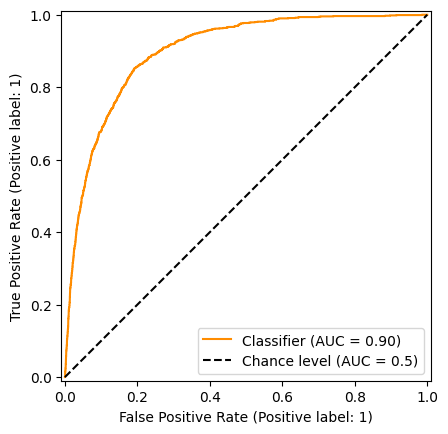

In [77]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
display = RocCurveDisplay.from_predictions(
  y_val,
  y_pred,
  color="darkorange",
  plot_chance_level=True,)

In [78]:
auc(fpr, tpr)

0.9003530175710851

In [79]:
roc_auc_score(y_val, y_pred)

0.9003530175710851

### Precision & Recall

In [80]:
def precision_recall_df(y_true, y_pred):
  thresholds = np.linspace(0, 1, 101)

  scores = []

  for t in thresholds:
    recall = recall_score(y_true, y_pred >= t)
    precision = precision_score(y_true, y_pred >= t)
    f1 = f1_score(y_true, y_pred >= t)

    scores.append((t, recall, precision, f1))
  
  df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'f1_score'])

  return df_scores

In [81]:
def plot_precision_recall(df: pd.DataFrame):
  plt.plot(df.threshold, df.precision, label='precision')
  plt.plot(df.threshold, df.recall, label='recall')

  plt.title('Precision & Recall by Threshold')
  plt.xlabel('Threshold')
  plt.ylabel('Precision/Recall')

  plt.legend()
  plt.show()

In [82]:
df_scores = precision_recall_df(y_val, y_pred)

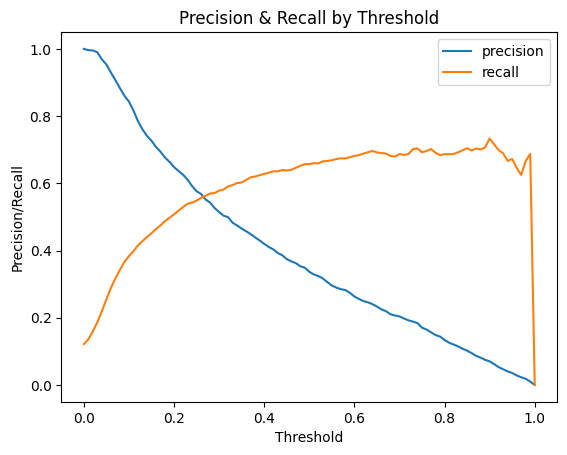

In [83]:
plot_precision_recall(df=df_scores)

In [84]:
df_scores.loc[df_scores.f1_score == df_scores.f1_score.max(), 'threshold']

22    0.22
Name: threshold, dtype: float64

## Cross-Validation

In [85]:
def train(df:pd.DataFrame, y_train: np.array, C=1.0):
  X_train, dv = encode_vars(df)
  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
  model.fit(X_train, y_train)

  return dv, model

In [86]:
def predict(df: pd.DataFrame, dv, model):
  X, _ = encode_vars(df, dv)
  y_pred = model.predict_proba(X)[:, 1]

  return y_pred

In [87]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [88]:
scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx, :]
    df_val = df_train_full.iloc[val_idx, :]

    y_train = y_train_full.iloc[train_idx]
    y_val = y_train_full.iloc[val_idx]

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc_score = roc_auc_score(y_val, y_pred)
    scores.append(auc_score)
    

In [89]:
np.std(scores)

0.005663554526910946

## Parameter Tuning

In [90]:
C_vals = [0.000001, 0.001, 1]

In [91]:
for C_val in C_vals:
  kfold = KFold(n_splits=5, shuffle=True, random_state=1)

  scores = []

  for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx, :]
    df_val = df_train_full.iloc[val_idx, :]

    y_train = y_train_full.iloc[train_idx]
    y_val = y_train_full.iloc[val_idx]

    dv, model = train(df_train, y_train, C=C_val)
    y_pred = predict(df_val, dv, model)

    auc_score = roc_auc_score(y_val, y_pred)
    scores.append(auc_score)
  print(f'C={C_val} | AUC average={round(np.mean(scores), 3)} | AUC std={round(np.std(scores), 3)}')
    

C=1e-06 | AUC average=0.701 | AUC std=0.009
C=0.001 | AUC average=0.861 | AUC std=0.007
C=1 | AUC average=0.906 | AUC std=0.006
